In [2]:
import pandas as pd
import d2l.torch as d2l
import torch
from torch.nn import functional as F
from torch import nn
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from pandas.api.types import is_numeric_dtype
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve
import argparse
import random

torch.manual_seed(0)
plt.rcParams["figure.figsize"] = (40,30)
plt.tight_layout()

parser = argparse.ArgumentParser()
parser.add_argument("--cuda_start_idx", type=int, help="starting index for cuda device", default=0)
args = parser.parse_args()
print(args.cuda_start_idx)

usage: ipykernel_launcher.py [-h] [--cuda_start_idx CUDA_START_IDX]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/pwnphofun/.local/share/jupyter/runtime/kernel-9614351d-325e-432e-a110-401fd921b3f4.json


SystemExit: 2

/home/pwnphofun/miniconda3/envs/d2l/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<Figure size 4000x3000 with 0 Axes>

In [14]:
print(f"num_gpus: {d2l.num_gpus()}")
device = torch.device(f"cuda:{args.cuda_start_idx}")
print(f"Using this GPU device: {device}")
t = torch.tensor([1,2,3]).to(device)
print(f"Test tensor with this device: {t}")

num_gpus: 0


NameError: name 'args' is not defined

In [27]:
plt.rcParams["figure.figsize"] = (45,35)

In [3]:
dfs = pd.read_csv(f"./data/combined_correct_datasets.csv")

In [13]:
class DataModule(d2l.HyperParameters):
    """The base class of data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, is_train=True):
        raise NotImplementedError


    def train_dataloader(self):
        return self.get_tensorloader([self.train_X, self.train_Y], is_train=True)

    def val_dataloader(self):
        return self.get_tensorloader([self.val_X, self.val_Y], is_train=False)
        
    def thresh_dataloader(self):
        return self.get_tensorloader([self.thresh_X, self.thresh_Y, self.thresh_labels, self.thresh_times], is_train=False)
        
    def test_dataloader(self):
        return self.get_tensorloader([self.test_X, self.test_Y, self.test_labels, self.test_times], is_train=False)


    def get_tensorloader(self, tensors, is_train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=is_train)

class PlaneData(DataModule):
    def __init__(self, data_frame, trunc_num = 5000, batch_size=64, 
                 num_steps = 50, train_val_ratio = 0.8, thresh_test_ratio = 0.5, is_test = False):
        """
        So the normal flights (without anomalies. label = 0) will be the training dataset
        Each normal flight is splitted into regression training and regression validation using `train__val_ratio`
        Then, we will use anomalous flights to determine a validation threshold, using the same spltiting with `thresh_test_ratio` instead
        So now the bad flights is splitted into threshold determination set and testing set 
        Finally, we use the testing dataset to compute all the metrics for a threshold
        The second dataset (thresholding and test dataset) will contain a labels tensor
        """
        
        super().__init__()
        self.save_hyperparameters()
        
        # only visualizing `trunc_num` data points/rows.
        # group by label (bad/normal flights), then group by flight_id, then sort data by timestamp
        all_data = data_frame.iloc[:trunc_num]

        start = time.time()
        groups = all_data.groupby("label") 

        normal_flights = groups.get_group(0).groupby("flight_id")
        normal_flights = [flight for _, flight in normal_flights]
        bad_flights = groups.get_group(1).groupby("flight_id")
        bad_flights = [flight for _, flight in bad_flights]

        # # Select 50 normal flights to move to test set and 30 bad flights to move to training set
        # random_indices_normal = random.sample(range(len(normal_flights)), 50)  # Indices of normal flights to move to test
        # random_indices_bad = random.sample(range(len(bad_flights)), 30)       # Indices of bad flights to move to training
        
        # # Sort indices in descending order to avoid index shifting when popping
        # random_indices_normal.sort(reverse=True)
        # random_indices_bad.sort(reverse=True)

        # bad_in_normal, normal_in_bad = [], []
        # for i in random_indices_normal:
        #     normal_in_bad.append(normal_flights.pop(i)) # pop then add
        # for i in random_indices_bad:
        #     bad_in_normal.append(bad_flights.pop(i)) # pop then add

        # normal_flights = normal_flights + bad_in_normal
        # bad_flights = bad_flights + normal_in_bad

        # random.shuffle(normal_flights)
        # random.shuffle(bad_flights)
        
        self.bad_flights = bad_flights

        num_thresh_flights = int(len(bad_flights)* thresh_test_ratio)

        print(f"# normal flights: {len(normal_flights)}")
        print(f"# bad flights: {len(bad_flights)}")
        print(f"# thresh flights: {num_thresh_flights}")
        print(f"# test flights: {len(bad_flights) - num_thresh_flights}")
        
        #all_flights = pd.concat(normal_flights)
        all_flights = pd.concat(normal_flights)
        all_flights = all_flights.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)
        
        scaler = MinMaxScaler()
        scaler.fit(all_flights)
        # print("[+] Scaler's information: ")
        # print("Min: ", scaler.data_min_)
        # print("Max: ", scaler.data_max_)
        self.scaler = scaler
        
        self.train_X = []
        self.val_X = []
        self.train_Y = []
        self.val_Y = []
        self.thresh_X, self.thresh_Y, self.thresh_labels, self.thresh_times = [], [], [], []
        self.test_X, self.test_Y, self.test_labels, self.test_times = [], [], [], []
        self.num_train = 0
        self.num_val = 0
        self.num_thresh = 0
        self.num_test = 0

        # sort each flight by time, then truncate to multiple of num_steps, then scale it separately from other flights
        # Then combine it into the training/val sets
        for flight in normal_flights:
            flight = flight.sort_values(by="time", kind="stable")
                
            flight = flight.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)
            flight = flight.iloc[:len(flight) - (len(flight) % self.num_steps)]
            
            self.label_names = flight.columns.tolist()

            scaled = scaler.transform(flight) # scale 
            scaled_tensor = torch.tensor(scaled, dtype=torch.float32)

            # Create input-output pairs
            X_seqs, Y_seqs = self.create_sequences(scaled_tensor)
            for i in range(1, X_seqs.shape[0]):
                assert(X_seqs[i][-1].equal(Y_seqs[i-1]))

            # split this flight into train/val sets
            num_train = int(len(X_seqs) * self.train_val_ratio)
            num_val = len(X_seqs) - num_train
            self.num_train += num_train
            self.num_val += num_val
            
            self.train_X.append(X_seqs[:num_train])
            self.train_Y.append(Y_seqs[:num_train])
            self.val_X.append(X_seqs[num_train:])
            self.val_Y.append(Y_seqs[num_train:])

        # After processing all flights, concatenate along the batch dimension
        self.train_X = torch.cat(self.train_X, dim=0)  # (total_sequences, num_steps - 1, num_features)
        self.train_Y = torch.cat(self.train_Y, dim=0)  # (total_sequences, num_features)
        self.val_X = torch.cat(self.val_X, dim=0)  # (total_sequences, num_steps - 1, num_features)
        self.val_Y = torch.cat(self.val_Y, dim=0)  # (total_sequences, num_features)
        
        # shape of X: (number of sequences, num_steps, # of features of the raw data) 
        # last dim is the number of different features (e.g. pitch, roll, etc) that each data point has
        # X is input, Y is label.
        # Y is the data point after X.
        print("train_X's shape: ", self.train_X.shape)
        print("train_Y's shape: ", self.train_Y.shape)
        print("val_X's shape: ", self.val_X.shape)
        print("val_Y's shape: ", self.val_Y.shape)

        # Same thing as the above loop, with `thresh_flight_ids` instead
        self.bad_flight_ids = []
        for i in range(num_thresh_flights):
            flight = bad_flights[i].sort_values(by="time", kind="stable")
            flight = flight.iloc[:len(flight) - (len(flight) % self.num_steps)]
            labels = flight["is_fail"].values # this line is different from the first loop
            times = flight["time"].values # this line is different from the first loop
            
            flight_ids = flight["flight_id"].values

            
            if flight_ids[0] == "45FOELI6":
                self.bruh = flight
                self.bruh_times = times
                self.bruh_labels = labels
                
            flight = flight.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)

            self.label_names = flight.columns.tolist()
            
            scaled = scaler.transform(flight) # scale 
            scaled_tensor = torch.tensor(scaled, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.float32)
            times_tensor = torch.tensor(times, dtype=torch.float32)

            if flight_ids[0] == "45FOELI6":
                self.bruh_scaled = scaled
            
            # Create input-output pairs
            X_seqs, Y_seqs, labels, times = self.create_sequences(scaled_tensor, labels_tensor, times_tensor)
            for j in range(1, X_seqs.shape[0]):
                assert(X_seqs[j][-1].equal(Y_seqs[j-1]))
            
            self.thresh_X.append(X_seqs)
            self.thresh_Y.append(Y_seqs)
            self.thresh_times.append(times)
            self.thresh_labels.append(labels)
            # fail_idx = (labels == 1).nonzero(as_tuple=True)[0]
            # self.thresh_X.append(X_seqs[fail_idx])
            # self.thresh_Y.append(Y_seqs[fail_idx])
            # self.thresh_times.append(times[fail_idx])
            # self.thresh_labels.append(labels[fail_idx])

            flight_ids = flight_ids[self.num_steps:]
            self.bad_flight_ids.append(flight_ids[0])


        self.test_flight_ids = []
         # Same thing as the above loop, with `test_flight_ids` instead
        for i in range(num_thresh_flights, len(bad_flights)):
            flight = bad_flights[i].sort_values(by="time", kind="stable")
            flight = flight.iloc[:len(flight) - (len(flight) % self.num_steps)]
            labels = flight["is_fail"].values # this line is different from the first loop
            times = flight["time"].values # this line is different from the first loop
            flight_ids = flight["flight_id"].values
            flight = flight.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)


            self.label_names = flight.columns.tolist()

            scaled = scaler.transform(flight) # scale 
            scaled_tensor = torch.tensor(scaled, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.float32)
            times_tensor = torch.tensor(times, dtype=torch.float32)

            # Create input-output pairs
            X_seqs, Y_seqs, labels, times = self.create_sequences(scaled_tensor, labels_tensor, times_tensor)
            for j in range(1, X_seqs.shape[0]):
                assert(X_seqs[j][-1].equal(Y_seqs[j-1]))
            
            self.test_X.append(X_seqs)
            self.test_Y.append(Y_seqs)
            self.test_times.append(times)
            self.test_labels.append(labels)
            self.test_flight_ids += list(flight_ids[self.num_steps:])
            # fail_idx = (labels == 1).nonzero(as_tuple=True)[0]
            # self.test_X.append(X_seqs[fail_idx])
            # self.test_Y.append(Y_seqs[fail_idx])
            # self.test_times.append(times[fail_idx])
            # self.test_labels.append(labels[fail_idx])
            
        
        # After processing all flights, concatenate along the batch dimension
        self.thresh_X = torch.cat(self.thresh_X, dim=0)  # (total_sequences, num_steps - 1, num_features)
        self.thresh_Y = torch.cat(self.thresh_Y, dim=0)  # (total_sequences, num_features)
        self.thresh_labels = torch.cat(self.thresh_labels, dim=0) # (total_sequences, 1)
        self.thresh_times = torch.cat(self.thresh_times, dim=0)
        self.test_X = torch.cat(self.test_X, dim=0)  # (total_sequences, num_steps - 1, num_features)
        self.test_Y = torch.cat(self.test_Y, dim=0)  # (total_sequences, num_features)
        self.test_labels = torch.cat(self.test_labels, dim=0) # (total_sequences, 1)
        self.test_times = torch.cat(self.test_times, dim=0)

        # shape of X: (number of sequences, num_steps, # of features of the raw data) 
        # last dim is the number of different features (e.g. pitch, roll, etc) that each data point has
        # X is input, Y is label.
        # Y is the data point after X.
        print("thresh_X's shape: ", self.thresh_X.shape)
        print("thresh_Y's shape: ", self.thresh_Y.shape)
        print("test_X's shape: ", self.test_X.shape)
        print("test_Y's shape: ", self.test_Y.shape)
        
        end = time.time()
        print(f"Processing Time: {end - start}")

    
    def create_sequences(self, flight: torch.Tensor, labels: torch.Tensor = None, times: torch.Tensor = None):
        """
        Create input-output sequences from a single flight tensor.
        
        Args:
            flight (torch.Tensor): Tensor of shape (num data points, num_features)
        
        Returns:
            X (torch.Tensor): Input sequences of shape (num_sequences, num_steps - 1, num_features)
            Y (torch.Tensor): Targets of shape (num_sequences, num_features)
        """
        X, Y = [], []
        num_seqs = flight.shape[0] - self.num_steps
        if num_seqs <= 0:
            raise f"Not Enough Sequences. flight.shape[0] = {flight.shape[0]}, self.num_steps = {self.num_steps}"
        # broadcast then add. Shape of X_indices: (num_seqs, num_steps)
        # basically, X_indices[i] = [i, i + 1, ... , i + self.num_steps - 1] is the i-th sequence from the dataset
        X_indices = torch.arange(num_seqs)[:, None] + torch.arange(self.num_steps) 
        X = flight[X_indices] # Shape of X: (num_seqs, num_steps, num_features)
        Y = flight[self.num_steps:] # Shape of Y: (num_seqs, num_features)
        if labels is None:
            return X, Y
        else:
            return X, Y, labels[self.num_steps:], times[self.num_steps:]


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P, shape of P: (max sequence length, input embeddings dim = num_hiddens)
        self.P = torch.zeros((1, max_len, num_hiddens))
        # initialize the positional encoding
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        # 0::2 in the third dimension means "select every second element starting from index 0."
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        # make sure the second dim matches
        X = X + self.P[:, X.shape[1], :].to(X.device)
        return self.dropout(X)

class PositionwiseFFN(nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(num_hiddens)
        self.gelu = nn.GELU()
        self.dense2 = nn.LazyLinear(num_outputs)

    def forward(self, X):
        return self.dense2(self.gelu(self.dense1(X)))
        
        
class TransformerEncoder(nn.Module):
    def __init__(self, num_hiddens, num_hiddens_ffn, num_blks, num_hiddens_latent, 
                 num_heads=4, dropout=0.2, bias=True):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        # self.embed = nn.LazyLinear(num_hiddens) # project to higher dimension
        self.pos_encoding = PositionalEncoding(num_hiddens)
        self.blks = nn.Sequential()
        for i in range(self.num_blks):
            self.blks.add_module(f"blk#{i}", TransformerEncoder(num_hiddens, num_hiddens_ffn, num_heads, 
                                                                dropout, bias))
    
    def forward(self, X):
        X = self.pos_encoding(self.embed(X))
        
    

class Transformer(nn.Module):
    def __init__(self, num_hiddens, num_hiddens_ffn, num_blks, num_heads, dropout, bias=True):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        
    def forward(self, X):
        pass
    

In [6]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)


class RNN(d2l.Module):
    def __init__(self, num_features, num_hiddens, num_hiddens_ffn, num_hiddens_latent, 
                 num_lstm_layers, dropout=0.2, bias=True, lr = 0.1):
        
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_features, num_hiddens, num_layers = 2, batch_first = True, bias = True)

    def init_weights(self):
        self.apply(init_normal)

    def forward(self, X, H_C = None):
        return self.rnn(X, H_C)


In [7]:
# input shape: (batch_size, # channels, seq len)
w = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3, padding=1, bias=False)
w.weight = torch.nn.Parameter(torch.ones(5, 5, 3) + torch.arange(5).reshape(5,1,1)) # hardcode the weight without bias to easily visualize
tmp = torch.arange(20, dtype=torch.float32).reshape(1, 5, 4)
print(w.weight)
print(tmp)
output = w(tmp)
print(output)
for i in range(1): # batch 
    for j in range(5): # feature out
        for l in range(4): # seq len
            s = 0
            for f in range(5): # feature in
                for k in range(3): # kernel size
                    idx = l - int(3/2) + k 
                    if idx < 0 or idx >= 4:
                        continue
                    s += w.weight[j][f][k]*tmp[i][f][idx]
            assert s == output[i][j][l]
                    

Parameter containing:
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[4., 4., 4.],
         [4., 4., 4.],
         [4., 4., 4.],
         [4., 4., 4.],
         [4., 4., 4.]],

        [[5., 5., 5.],
         [5., 5., 5.],
         [5., 5., 5.],
         [5., 5., 5.],
         [5., 5., 5.]]], requires_grad=True)
tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.]]])
tensor([[[ 85., 135., 150., 105.],
         [170., 270., 300., 210.],
         [255., 405., 450., 315.],
         [340., 540., 600., 420.],
         [425., 675., 750., 525.]]], grad_fn=<ConvolutionBackward0>)


In [7]:
class MainModel(d2l.Module):
    def __init__(self, rnn, num_features, dropout=0.2, lr = 0.1, wd = 1e-5):
        """
        num_features: how many features are there? Is the last dim of a batch: (batch_size, num_steps, num_inputs) 
        num_hiddens: dim for each variable (e.g. torque, yaw, etc)
        num_hiddens_ffn: for transformer
        num_blks: # enc blocks for transformer 
        num_heads: # heads for transformer encoder block
        num_hiddens_latent: for AE
        """
        super().__init__()
        self.save_hyperparameters()
        self.rnn = rnn
        self.rnn.init_weights()

        # oscillations are usually high frequency, so use a lower kernel size
        # self.conv = nn.Conv1d(in_channels = num_features, out_channels = num_hiddens, kernel_size = 5, padding=2, stride=1)
        # self.residual = nn.LazyLinear(num_hiddens)
        # self.residual_dropout = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.LazyLinear(num_features)
        self.init_weights()
        self.train_loss, self.val_loss = [], []

    def init_weights(self):
        self.apply(init_normal)
        
    def forward(self, X):
        """
        X's shape: (batch_size, seq len, # of features)
        `output`: final output of the each cell in the last layer, depth-wise
        `H`: final output of the last cell in a sequence in the batch, timestep-wise
        Check my notebook in Notion for a visualization of this
        output's shape: [batch size, num steps, hidden size)
        H's output: [batch size, hidden size]
        both output[:, -1, :] and h_n[-1, 
trainer = Trainer(max_epochs=50, num_gpus=1):, :] give (batch, hidden_size)
        """
        # lstm_output, (H, _) = self.rnn(X)
        # conv_output = self.conv(lstm_output.permute(0, 2, 1)) # conv expects (batch_size, # channel in, seq len) and outputs same shape
        # conv_output = conv_output.permute(0, 2, 1)
        # res = self.residual(X)
        # output = conv_output + res
        # conv_output = self.conv(X.permute(0, 2, 1)) # conv expects (batch_size, # channel in, seq len) and outputs same shape
        # conv_output = conv_output.permute(0, 2, 1)
        # combined = lstm_output + conv_output
        # combined = combined.mean(dim = 1) # shape: (batch_isze, num_hiddens)
        # return self.dense(combined)
        _, (H, _) = self.rnn(X)
        return self.dense(self.dropout(H[-1]))

    def loss(self, Y_hat, Y):
        # right now Y_hat is the output of the dense after the RNN with dim (batch_size, 1, num_features)
        fn = nn.MSELoss()
        #print(Y_hat.shape, Y.shape)
        return fn(Y_hat, Y)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])        
        self.plot('loss', l, train=True)
        return l
        
    def validation_step(self, batch):
        #print(len(batch), batch[0].shape, batch[-1].shape)
        l = self.loss(self(*batch[:-1]), batch[-1])        
        self.plot('loss', l, train=False)
        return l

In [8]:
class Trainer(d2l.Trainer):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        super().__init__(max_epochs)
        self.train_losses = []
        self.val_losses = []
        self.gpus = [d2l.gpu(args.cuda_start_idx + i) for i in range(min(num_gpus, d2l.num_gpus()))]

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.thresh_dataloader = data.thresh_dataloader()
        self.test_dataloader = data.test_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[5, 15, 30],gamma = 0.2)
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            self.scheduler.step()
            plt.savefig("./losses4_StandardScaler.png")
            
        self.find_best_threshold()
        self.evaluate_thresholds()      

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
                
            self.train_batch_idx += 1
            self.train_losses.append(float(loss))
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                loss = self.model.validation_step(self.prepare_batch(batch))
                self.val_losses.append(float(loss))
            self.val_batch_idx += 1

    def find_best_threshold(self):
        self.model.eval()
        
        errors_list, labels_list = [], []
        for batch in self.thresh_dataloader:
            X, Y, labels, _ = self.prepare_batch(batch)
            Y_hat = self.model(X)
            # shape of errors: (batch_size, num_features). 
            # Didn't use the self.model.loss function here as it will use a mean reduction over all batches. 
            errors = (Y_hat - Y) ** 2
            errors = errors.mean(dim=1) # get the mean error of all feature
            errors_list.append(errors.detach().cpu().numpy())
            labels_list.append(labels.cpu().numpy())

        self.errors_list = errors_list
        self.labels_list = labels_list
        thresh_errors = np.concatenate(errors_list)
        thresh_labels = np.concatenate(labels_list)
        precision, recall, self.thresholds = precision_recall_curve(thresh_labels, thresh_errors, pos_label=1)
        f1_scores = 2*(precision*recall) / (precision + recall + 1e-9)
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = self.thresholds[best_threshold_idx]
        best_f1 = f1_scores[best_threshold_idx]

        self.best_threshold_idx = best_threshold_idx
        self.best_threshold = best_threshold
        self.best_val_f1 = best_f1

        anomalies = thresh_errors > best_threshold
        tp = np.sum(anomalies & (thresh_labels == 1))
        fp = np.sum(anomalies & (thresh_labels == 0))
        tn = np.sum(~anomalies & (thresh_labels == 0))
        fn = np.sum(~anomalies & (thresh_labels == 1))

        print("Thresholding set's best threshold's metrics:")
        print(tp, fp, tn, fn)
        
        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec = tp / (tp + fn) if tp + fn > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn > 0 else 0
        
        print(f"Optimal Threshold (Thresholding Set): {best_threshold:.6f}")
        print(f"Thresholding Set Metrics: Precision: {prec:.6f}, Recall: {rec:.6f}, F1: {best_f1:.6f}, Accuracy: {acc:.6f}")

    def evaluate_thresholds(self):
        """
        Find reconstruction errors for the test set. Then for each threshold in self.thresholds,
        compute all the metrics against that threshold and graph them
        """
        if self.best_val_f1 is None:
            raise "Please run find_best_threshold() first!"
        
        self.model.eval()
        errors_list, labels_list = [], []
        for batch in self.test_dataloader:
            X, Y, labels, _ = self.prepare_batch(batch)
            Y_hat = self.model(X)
            # shape of errors: (batch_size, num_features). 
            # Didn't use the self.model.loss function here as it will use a mean reduction over all batch samples. 
            errors = (Y_hat - Y) ** 2
            # print(errors)
            errors = errors.mean(dim=1) # get the mean error of all feature
            # print(errors)
            # print(labels)
            # break
            errors_list.append(errors.detach().cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            
        test_errors = np.concatenate(errors_list)
        test_labels = np.concatenate(labels_list)
        self.test_errors = test_errors
        self.test_labels = test_labels
        test_precision = []
        test_recall = []
        test_f1 = []
        test_accuracy = []
        for thresh in self.thresholds:
            anomalies = test_errors > thresh
            tp = np.sum(anomalies & (test_labels == 1))
            fp = np.sum(anomalies & (test_labels == 0))
            tn = np.sum(~anomalies & (test_labels == 0))
            fn = np.sum(~anomalies & (test_labels == 1))
            prec = tp / (tp + fp) if tp + fp > 0 else 0
            rec = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (prec * rec) / (prec + rec + 1e-9) if prec + rec > 0 else 0
            acc = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn > 0 else 0
            test_precision.append(prec)
            test_recall.append(rec)
            test_f1.append(f1)
            test_accuracy.append(acc)
            
        best_test_idx = np.argmax(test_f1)
        best_test_threshold = self.thresholds[best_test_idx]
        print(f"Best Test Set Threshold: {best_test_threshold:.6f}")
        print(f"Test Set Metrics at Best Threshold: Precision: {test_precision[best_test_idx]:.6f}, "
              f"Recall: {test_recall[best_test_idx]:.6f}, F1: {test_f1[best_test_idx]:.6f}, "
              f"Accuracy: {test_accuracy[best_test_idx]:.6f}")
        
        # Visualize metrics vs. thresholds
        plt.figure(figsize=(10, 6))
        plt.plot(self.thresholds, test_precision, label="Precision", marker='.')
        plt.plot(self.thresholds, test_recall, label="Recall", marker='.')
        plt.plot(self.thresholds, test_f1, label="F1 Score", marker='.')
        plt.plot(self.thresholds, test_accuracy, label="Accuracy", marker='.')
        plt.axvline(x=self.best_threshold, color='red', linestyle='--', label=f"Optimal Threshold from Thresholding Set({self.best_threshold:.6f})")
        plt.axvline(x=best_test_threshold, color='orange', linestyle='--', label=f"Optimal Threshold from Test Set({best_test_threshold:.6f})")
        plt.xlabel("Threshold")
        plt.ylabel("Metric Value")
        plt.title("Metrics vs. Threshold on Test Set")
        plt.legend()
        plt.grid(True)
        plt.savefig("./metrics/metrics_vs_threshold_4.png")
        plt.close()

        # Precision-Recall Curve
        prc_test_precision, prc_test_recall, _ = precision_recall_curve(test_labels, test_errors, pos_label=1)
        plt.figure(figsize=(8, 6))
        plt.plot(prc_test_recall, prc_test_precision, label="Precision-Recall Curve")
        plt.scatter(test_recall[best_test_idx], test_precision[best_test_idx], color='orange',
                    label=f"Best Threshold from Test Set({best_test_threshold:.6f})")
        plt.scatter(test_recall[self.best_threshold_idx], test_precision[self.best_threshold_idx], color='red',
                    label=f"Best Threshold from Thresholding Set({self.best_threshold:.6f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve (Test Set)")
        plt.legend()
        plt.grid(True)
        plt.savefig("./metrics/precision_recall_4.png")
        plt.close()

In [19]:
num_steps = 50
data = PlaneData(dfs, trunc_num=-1, num_steps=num_steps, is_test=False)
#print(data.Y.shape)

# normal flights: 380
# bad flights: 202
# thresh flights: 101
# test flights: 101
train_X's shape:  torch.Size([167160, 50, 7])
train_Y's shape:  torch.Size([167160, 7])
val_X's shape:  torch.Size([41790, 50, 7])
val_Y's shape:  torch.Size([41790, 7])
thresh_X's shape:  torch.Size([55550, 50, 7])
thresh_Y's shape:  torch.Size([55550, 7])
test_X's shape:  torch.Size([55550, 50, 7])
test_Y's shape:  torch.Size([55550, 7])
Processing Time: 2.110393524169922


In [11]:
# pairs = zip(data.thresh_labels, data.thresh_times)
# bad_points = list(filter(lambda p: p[0] == 1, pairs))

In [12]:
# num_graphs = data.train_X.shape[2]
# col_names = data.label_names
# dd = torch.transpose(data.train_X[2139], 0, 1)
# t = [i for i in range(dd.shape[1])]
# for i in range(num_graphs):
#     fig, ax = plt.subplots(1, figsize=(10, 5))

#     ax.set_ylabel(col_names[i])
#     ax.plot(t, dd[i])

In [1]:
# num_features = data.train_X.shape[2] 
# num_hiddens, num_hiddens_ffn, num_blks, num_hiddens_latent = 256, 128, 4, 64
# num_lstm_layers = 2
# num_heads, dropout, bias, lr = 4, 0.2, True, 1e-2
# rnn = RNN(num_features, num_hiddens, num_hiddens_ffn, num_hiddens_latent, 
#              num_lstm_layers, dropout, bias, lr)
# model = MainModel(rnn, num_features, dropout, lr)

# trainer = Trainer(max_epochs=75, num_gpus=8)
# trainer.fit(model, data)
# torch.save(model.state_dict(), 'model_weights_without_labels_MSE2.pth')

NameError: name 'data' is not defined

In [20]:
num_features = data.train_X.shape[2] 
num_hiddens, num_hiddens_ffn, num_blks, num_hiddens_latent = 256, 128, 4, 64
num_lstm_layers = 2
num_heads, dropout, bias, lr = 4, 0.2, True, 1e-2
rnn = RNN(num_features, num_hiddens, num_hiddens_ffn, num_hiddens_latent, 
             num_lstm_layers, dropout, bias, lr)
model = MainModel(rnn, num_features, lr)
model.load_state_dict(torch.load('./model_weights_without_labels_MSE2.pth', weights_only=True,  map_location=torch.device('cpu')))
trainer = Trainer(max_epochs=100, num_gpus=8)
trainer.prepare_data(data)
trainer.prepare_model(model)
trainer.find_best_threshold()
trainer.evaluate_thresholds()  

Thresholding set's best threshold's metrics:
6 2354 53127 63
Optimal Threshold (Thresholding Set): 1.262516
Thresholding Set Metrics: Precision: 0.002542, Recall: 0.086957, F1: 0.005761, Accuracy: 0.956490
Best Test Set Threshold: 0.315961
Test Set Metrics at Best Threshold: Precision: 0.001288, Recall: 0.765625, F1: 0.002572, Accuracy: 0.315896


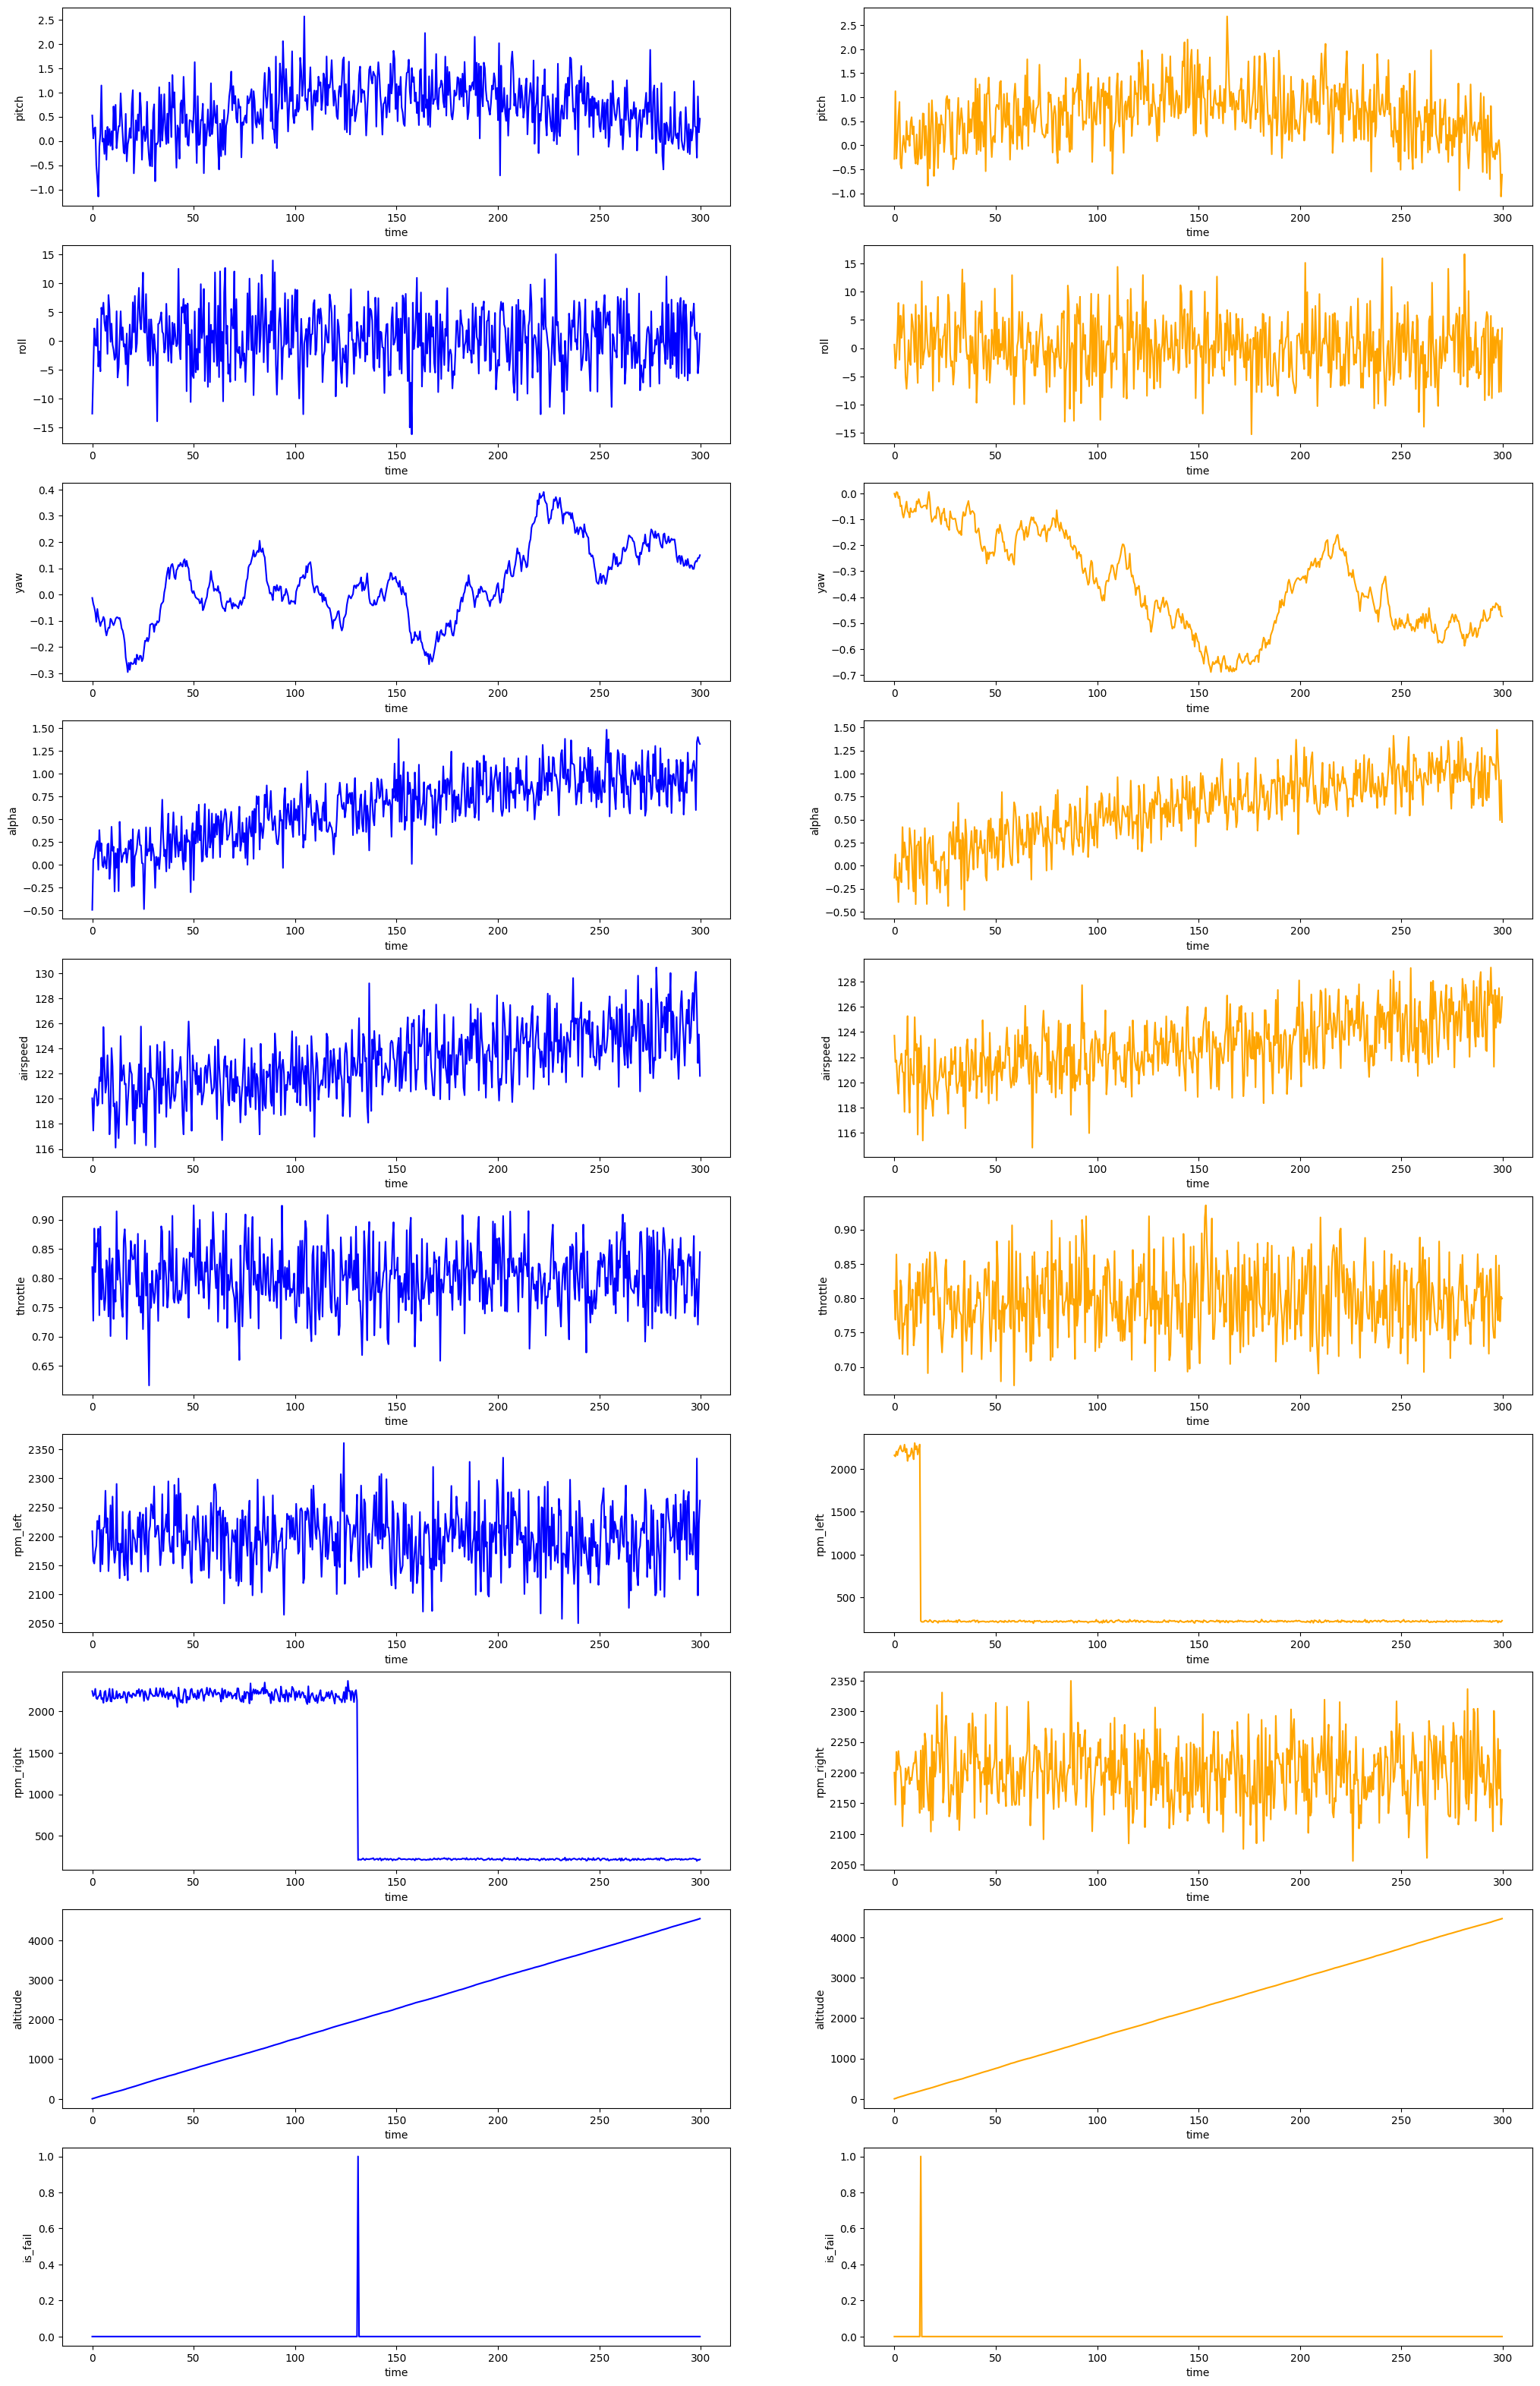

In [50]:
# tmp = data.bruh[100:2000]
# tmp = dfs[dfs["flight_id"] == "HPEGXM74"]
tmp = dfs[dfs["flight_id"] == "OJSZQOA1"]
t = len(tmp)
# tmp = tmp.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)
tmp = tmp.drop(["time", "flight_id", "label"], axis=1)
col_names = list(tmp.columns.values)
flight_ids = ["52DFW4TE", "9RWG5YM4"]
colors = ["blue", "orange"]
fig, axes = plt.subplots(len(col_names), 2, figsize=(25, 40))

for i in range(len(flight_ids)):
    # tmp = data.scaler.transform(tmp) # will return a NumPy array object :heartbreak:
    # tmp = pd.DataFrame(tmp, columns=col_names) # transform back to we can graph ts
    tmp = dfs[dfs["flight_id"] == flight_ids[i]]
    tmp = tmp.sort_values("time", kind="stable")
    times = tmp["time"].values
    tmp = tmp.drop(["time", "flight_id", "label"], axis=1)
    
    for j in range(len(col_names)):
        axes[j, i].set_ylabel(col_names[j])
        axes[j, i].set_xlabel("time")
        axes[j, i].plot(times, tmp[col_names[j]], color=colors[i])

plt.savefig("./normal_vs_bad.png")

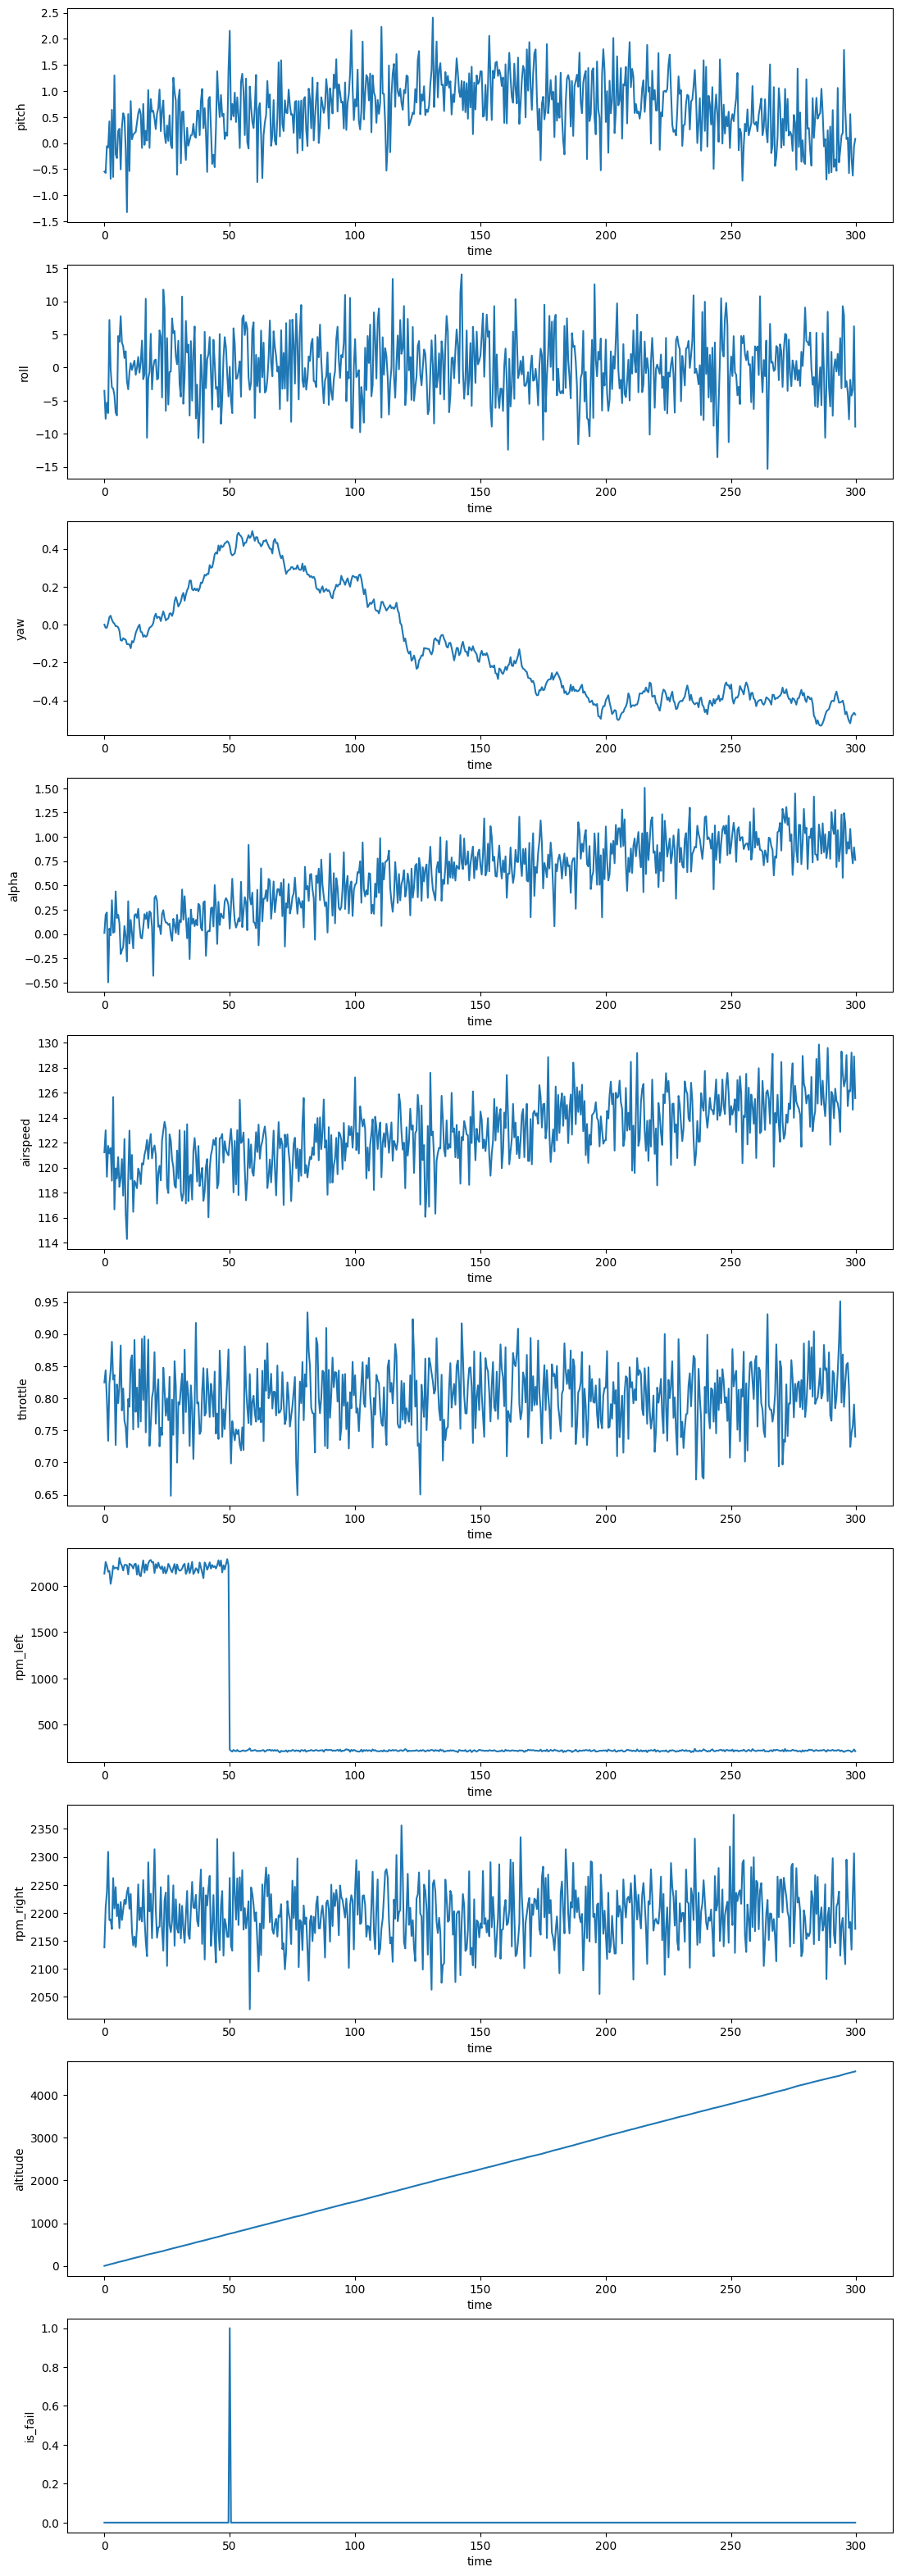

In [36]:
# tmp = data.bruh[100:2000]
tmp = dfs[dfs["flight_id"] == "HPEGXM74"]
# tmp = dfs[dfs["flight_id"] == "OJSZQOA1"]
t = len(tmp)
times = tmp["time"].values
# tmp = tmp.drop(["time", "flight_id", "label", "is_fail", "rpm_left", "rpm_right"], axis=1)
tmp = tmp.drop(["time", "flight_id", "label"], axis=1)
#tmp = tmp[["roll", "rpm_right"]]
col_names = list(tmp.columns.values)
# tmp = data.scaler.transform(tmp) # will return a NumPy array object :heartbreak:
tmp = pd.DataFrame(tmp, columns=col_names) # transform back to we can graph ts

fig, axes = plt.subplots(len(col_names), 1, figsize=(13, 40))
for i in range(len(col_names)):
    axes[i].set_ylabel(col_names[i])
    axes[i].set_xlabel("time")
    axes[i].plot(times, tmp[col_names[i]])
# plt.savefig("./tmp_StandardScaler.pnmodel_weights_without_labels_MSE.png")

In [549]:
# print(trainer.labels_list)

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.], dtype=float32)]


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
    
count_parameters(model)

In [ ]:
# col_names = data.label_names

# # get 5 sequences, then flatten the first 2 dim out to be the pseudo-time dim so we can graph it.
# data_X = data.val_X[:8]
# data_Y = data.val_Y[:8]
# num_graphs = data_Y.shape[1]
# # t = torch.arange(data_X.shape[0]*data_X.shape[1])

# print(data_X.shape, data_Y.shape)
# for i in range(num_graphs):
#     fig, axes = plt.subplots(1, figsize=(13, 4), sharex="col", sharey="row")
#     plt.subplots_adjust(hspace=0.05, wspace=0.05)  # Reduced wspace from default (~0.2) to 0.1

#     # .reshape(-1, data.X.shape[2])
#     # for each label, plot it with its input
#     axes.set_ylabel(col_names[i])
#     axes.legend(["Input", "Label"])
#     num_steps = data_X.shape[1]
#     t_Y = -1
#     for j in range(data_Y.shape[0]):
#         t_X = torch.arange(start = t_Y + 1, end = t_Y + num_steps + 1) 
#         t_Y = t_Y + num_steps + 1
#         axes.plot(t_X, data_X[j, :, i]) # input sequence
#         axes.plot(t_Y, data_Y[j, i], color="red", marker='o', markersize=10) # label

In [30]:
with open("./losses4.txt", "w") as f:
    f.write(", ".join([str(i) for i in trainer.train_losses]))
    f.write("\n")
    f.write(", ".join([str(i) for i in trainer.val_losses]))

In [1]:
net = nn.LazyLinear(5) # dummy net
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 7, 9, 15, 20, 25, 40, 45], gamma = 0.5)

def get_lr(optimizer, scheduler):
    lr = scheduler.get_last_lr()[0]
    optimizer.step()
    scheduler.step()
    print(lr)
    return lr

d2l.plot(torch.arange(100), [get_lr(optimizer, scheduler)
                                  for t in range(100)])

NameError: name 'nn' is not defined

######################
torch.Size([178])
torch.Size([7, 177])
torch.Size([7, 128])
torch.Size([7, 128])
True


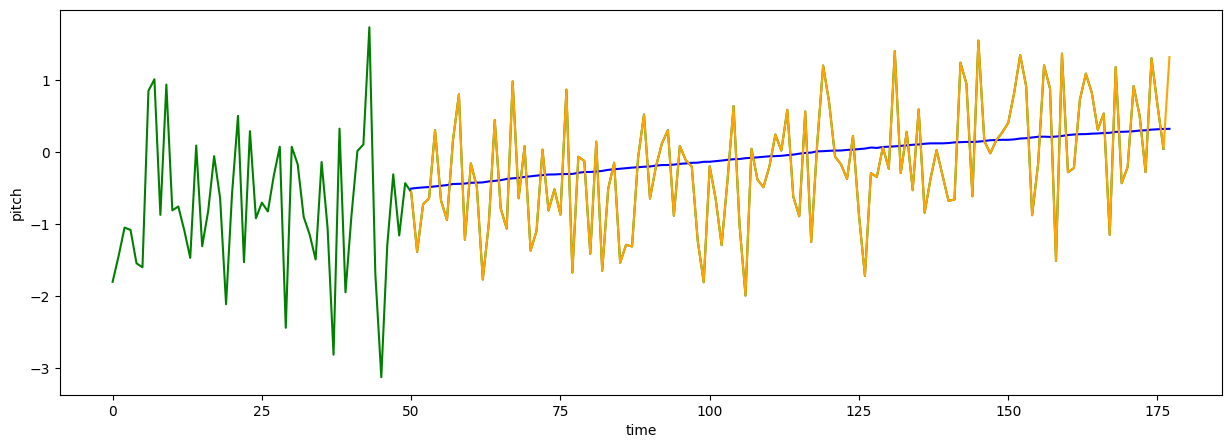

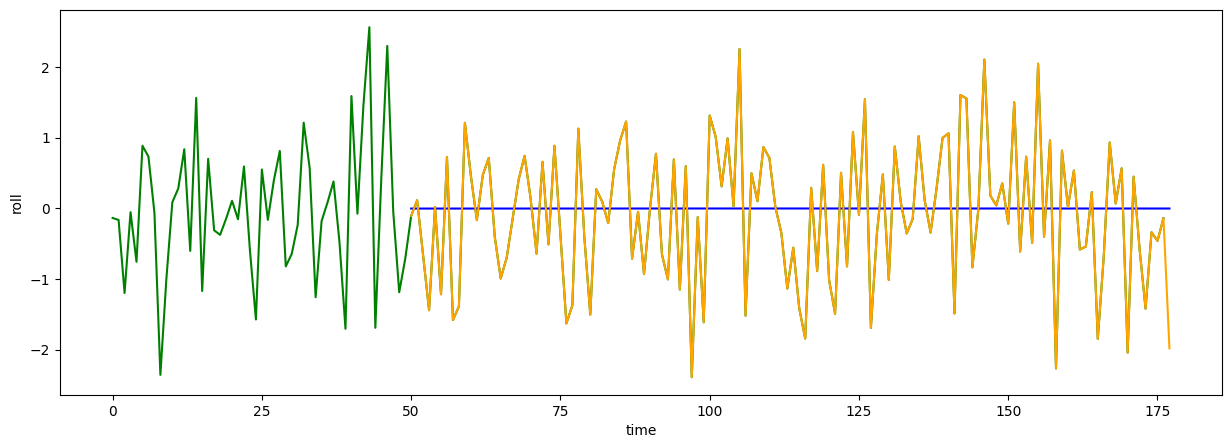

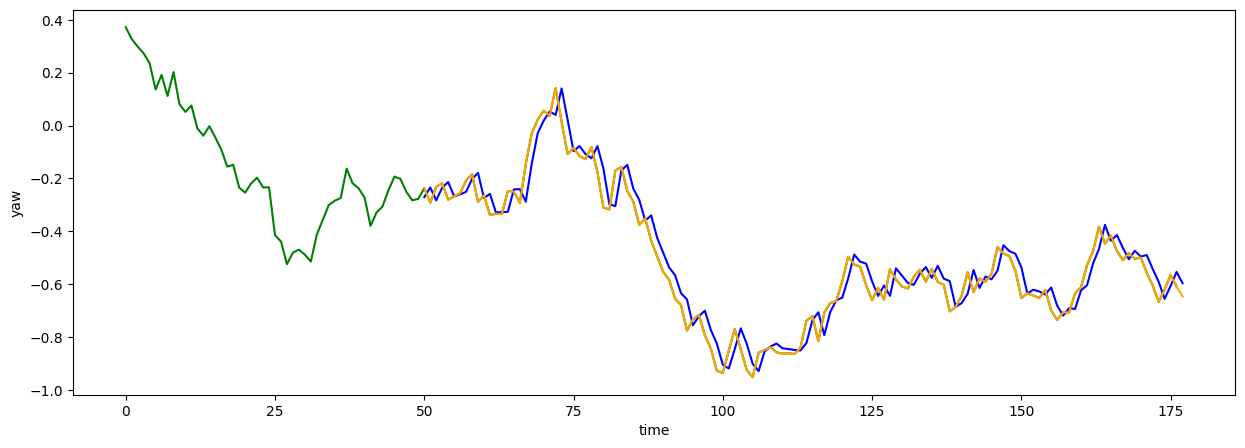

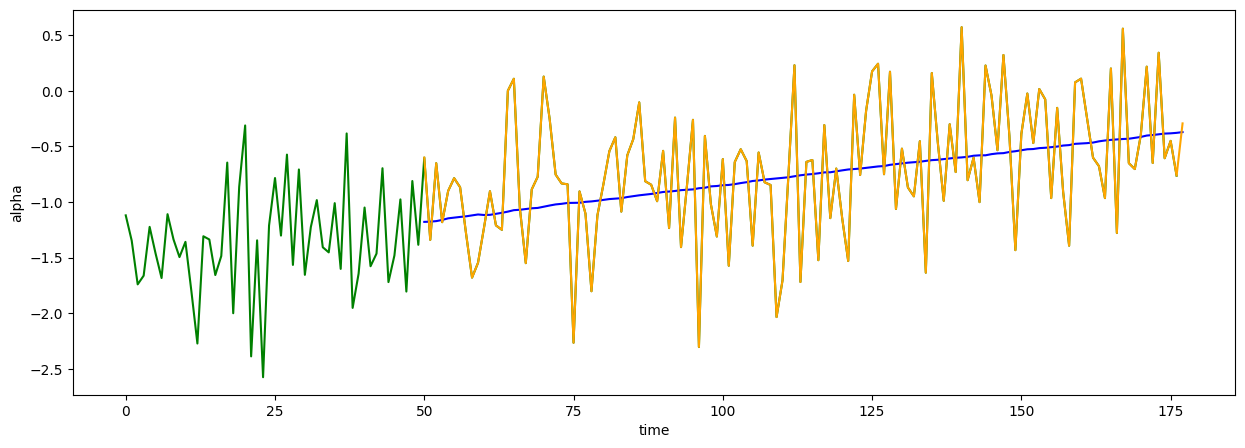

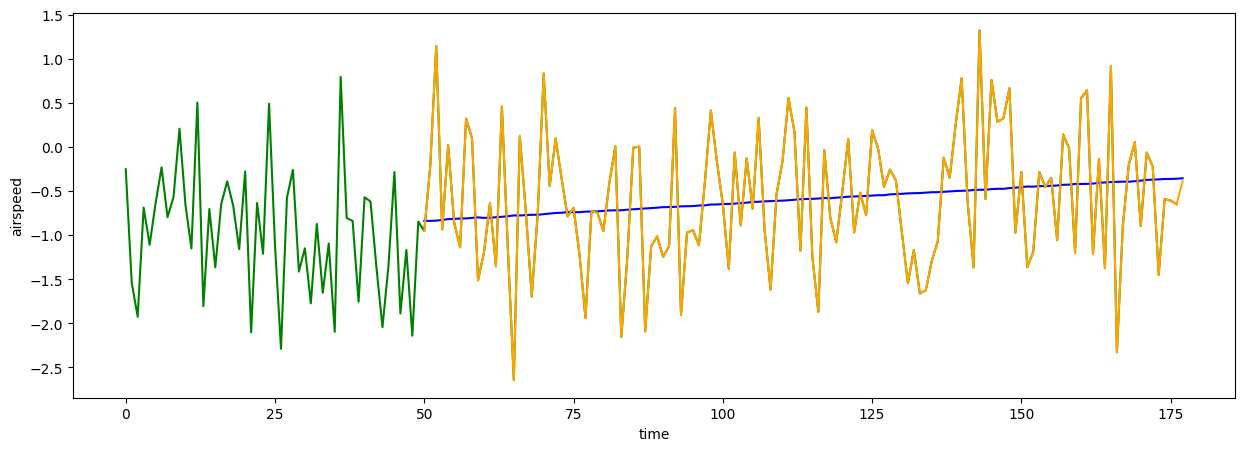

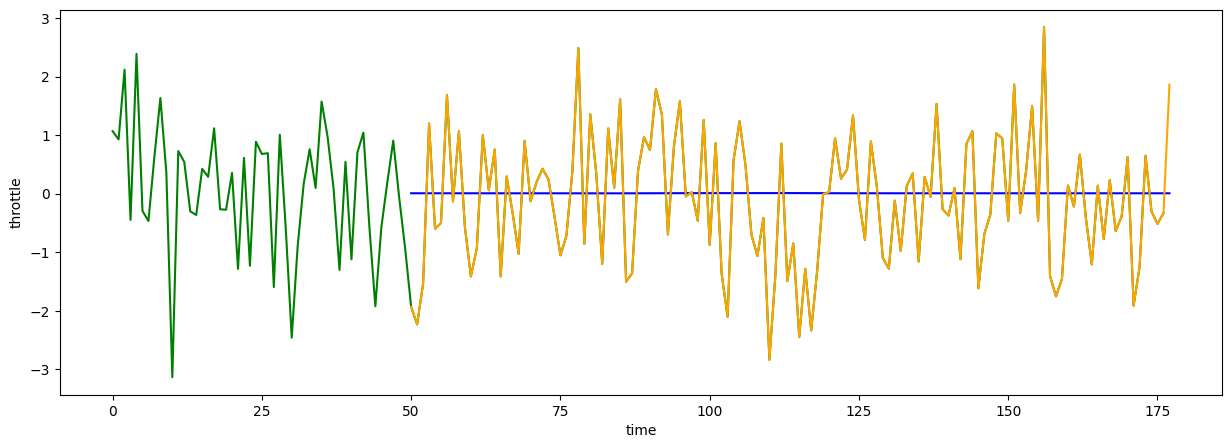

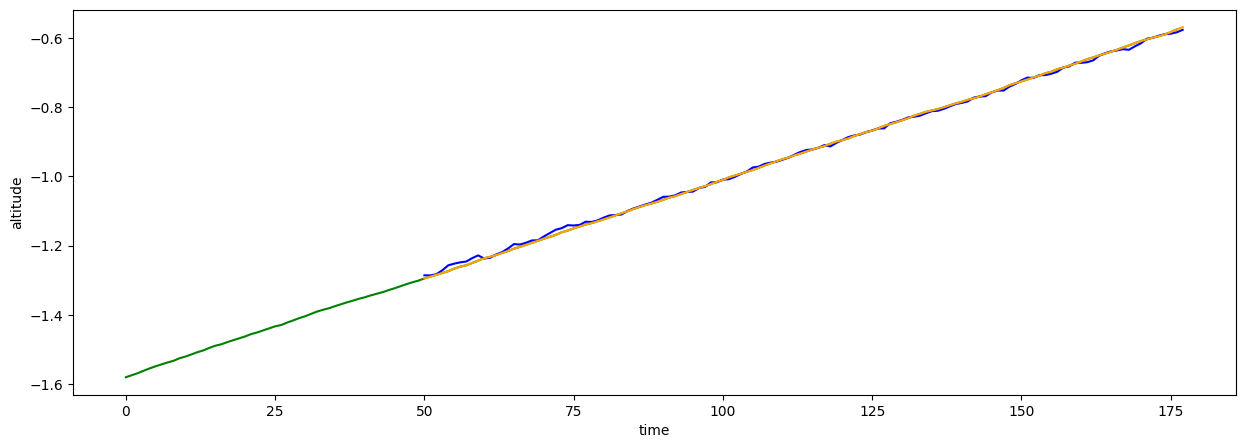

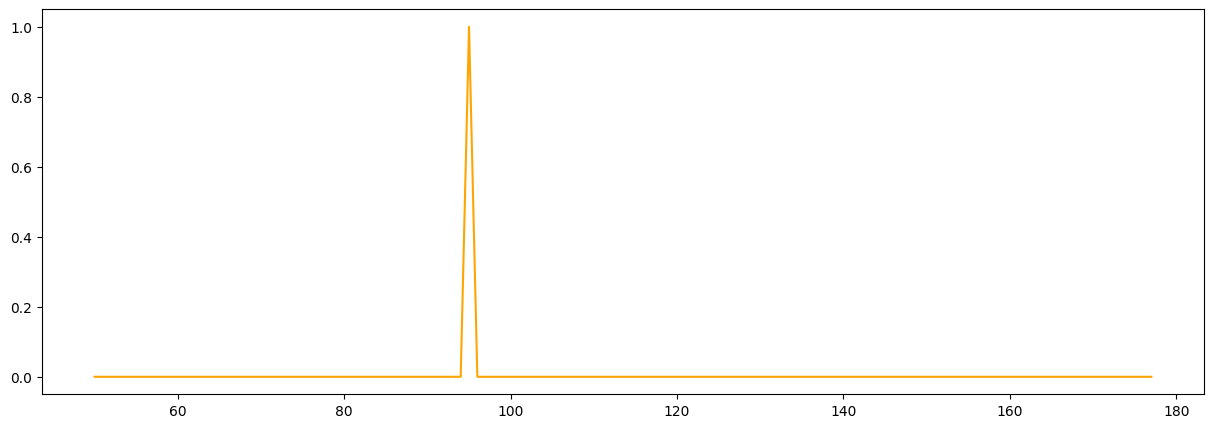

In [29]:
device="cpu"
# Plot Y_hat against Y
def plot(t, Y_hats, Ys, x_label=None, y_labels=None):
    num_graphs = len(Y_hats)
    for i in range(num_graphs):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # 1 row, 2 cols for Y_hat vs Y
        if y_labels is not None:
            axes[0].set_ylabel(y_labels[i])
            axes[1].set_ylabel(y_labels[i])
        if x_label is not None:
            axes[0].set_xlabel(x_label)
            axes[1].set_xlabel(x_label)
        axes[0].plot(t, Y_hats[i], color="blue")
        axes[1].plot(t, Ys[i], color="orange")


"""
Plot X,Y_hat against Y. 
`delay` to account for the initial time steps where only X exists (i.e., Y_hat and Y begin `delay` steps after X)
`labels`: 1 if that is the point of failure
"""
def plot_X(t, X, Y_hats, Ys, labels=None, delay=data.num_steps, x_label=None, y_labels=None):
    num_graphs = len(Y_hats)
    
    for i in range(num_graphs):
        # Pad with NaNs.
        x_padded = torch.cat( (X[i], torch.tensor([float("NaN")]) ) )
        y_hat_padded = torch.cat( (torch.full((delay, ), float("NaN")), Y_hats[i]) )
        y_padded = torch.cat( (torch.full((delay, ), float("NaN")), Y[i]) )
    
        fig, axes = plt.subplots(figsize=(15, 5)) # 1 row, 2 cols for Y_hat vs Y
        axes.plot(t, x_padded, color="green")
        axes.plot(t, y_hat_padded, color="blue")
        axes.plot(t, y_padded, color="orange")
        if x_label is not None:
            axes.set_xlabel(x_label)
        if y_labels is not None:
            axes.set_ylabel(y_labels[i])
    if labels is not None:
        fig, axes = plt.subplots(figsize=(15, 5)) # 1 row, 2 cols for Y_hat vs Y
        labels_padded = torch.cat( (torch.full((delay, ), float("NaN")), labels) )
        axes.plot(t, labels_padded, color="orange")

    plt.savefig("./tmp4.png")
        

j = 0
found = 0
X, Y_hat, Y, times, labels = torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])
for batch in trainer.test_dataloader:
    x,y,lab,t = batch
    if not found:
        if 1 in lab:
            found = True
    if found:
        #x, y= batch
        if j >= 0 and j <= 1:
            if len(X) == 0:
                X = x[0].to("cpu")
                for i in range(1, len(x)):
                    X = torch.cat((X, x[i][-1].to("cpu").unsqueeze(0)), dim=0)
            else:
                 for i in range(0, len(x)):
                    X = torch.cat((X, x[i][-1].to("cpu").unsqueeze(0)), dim=0)
            Y_hat = torch.cat((Y_hat, model(x.to(device)).to("cpu")), dim = 0)
            Y = torch.cat((Y, y.to("cpu")), dim = 0)
            labels = torch.cat((labels, lab.to("cpu")), dim=0)
            #times = torch.cat((times, t.to("cpu")), dim = 0)
            # print(Y_hat.shape)
            # print(Y.shape)
            # print(times.shape)
            
        j += 1

# labels = torch.transpose(labels.unsqueeze(1), 0, 1)
times = torch.arange(X.shape[0] + 1)
Y_hat = torch.transpose(Y_hat, 0, 1).detach()
Y = torch.transpose(Y, 0, 1).detach() # (num_features, batch_size) 
X = torch.transpose(X, 0, 1).detach()
print("######################")
print(times.shape)
print(X.shape)
print(Y_hat.shape)
print(Y.shape)

# print(Y_hat)
# print(Y)
print(Y_hat.shape == Y.shape)
plot_X(times, X, Y_hat, Y, labels, data.num_steps, "time", data.label_names)

In [ ]:
# Plot Y_hat against Y
def plot(t, Y_hats, Ys, x_label=None, y_labels=None):
    num_graphs = len(Y_hats)
    for i in range(num_graphs):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # 1 row, 2 cols for Y_hat vs Y
        if y_labels is not None:
            axes[0].set_ylabel(y_labels[i])
            axes[1].set_ylabel(y_labels[i])
        if x_label is not None:
            axes[0].set_xlabel(x_label)
            axes[1].set_xlabel(x_label)
        axes[0].plot(t, Y_hats[i], color="blue")
        axes[1].plot(t, Ys[i], color="orange")

i = 0
Y_hat, Y, times = torch.tensor([]), torch.tensor([]), torch.tensor([])
for batch in trainer.train_dataloader:
    if i >= 4 and i <= 6:
        x,y = batch
        t = torch.arange(len(times), len(times) + data.batch_size)
        Y_hat = torch.cat((Y_hat, model(x).to("cpu")), dim = 0)
        Y = torch.cat((Y, y.to("cpu")), dim = 0)
        times = torch.cat((times, t.to("cpu")), dim = 0)
        
    i += 1
Y_hat = torch.transpose(Y_hat, 0, 1).detach()
Y = torch.transpose(Y, 0, 1).detach()
#times = torch.transpose(times, 0, 1)

print(Y_hat)
print(Y)
print(Y_hat.shape == Y.shape)
plot(times, Y_hat, Y, "time", data.label_names)

In [814]:
p, r, t = precision_recall_curve([0, 1, 0, 1, 0, 0, 0, 1], [0.02, 0.08, 0.02, 0.09, 0.04, 0.04, 0.03, 0.07])

In [27]:
p, r, t

(array([0.375, 0.5  , 0.6  , 1.   , 1.   , 1.   , 1.   ]),
 array([1.        , 1.        , 1.        , 1.        , 0.66666667,
        0.33333333, 0.        ]),
 array([0.02, 0.03, 0.04, 0.07, 0.08, 0.09]))

In [25]:
y = torch.tensor([ [[1,2], [3,4]], [[4,5], [6,7]], [[8,9], [9, 10]] ], dtype=torch.float32)
x = torch.tensor([ [[3,4], [5,6]], [[7,8], [9,10]], [[11,12], [13, 14]] ], dtype=torch.float32)
loss = nn.MSELoss()
print(loss(x, y))
loss(x,y) == (4*4+9*6+16*2)/12

tensor(8.5000)


tensor(True)

In [752]:
import torch
lstm = torch.nn.LSTM(10, 20, num_layers=2, batch_first=True)
x = torch.randn(64, 50, 10)
out, (h_n, _) = lstm(x)

print(torch.allclose(out[:, -1, :], h_n[-1])) 

print(out[:, -1, :].shape)
print(h_n[-1].shape)

True
torch.Size([64, 20])
torch.Size([64, 20])


9